# **Object Detection in Satellite Imagery - Google/Aftershoot Project**

**Data Preprocessing and Cleaning**

1. Resizing Images:

All satellite images are resized to a standardized size of 64x64 pixels. This ensures that the input data is uniform in size, which is essential for feeding into the machine learning model.

2. Color Conversion (BGR to RGB):

Since OpenCV loads images in BGR format, the images are converted to RGB format to ensure consistency with most machine learning libraries, which typically expect RGB images. This step ensures that the colors in the images are interpreted correctly by the model.

3. Image Flattening:

The images, originally in 3D arrays (height, width, and color channels), are flattened into one-dimensional arrays. This allows each image to be represented as a vector of pixel values, which is necessary for most machine learning algorithms. This step essentially transforms the images into a format suitable for feeding into the model for training and inference.

4. Normalization of Pixel Values:

To ensure that the pixel values are on a consistent scale and to help the model converge faster during training, the pixel values are normalized to the range 0 to 1. This is done by dividing the original pixel values (which range from 0 to 255) by 255. Normalization reduces the variation in pixel intensity and helps the model perform better by preventing bias toward larger pixel values.

5. Label Assignment:

Each image is assigned a label based on its corresponding folder name (e.g., "Forest", "Residential"). These labels are crucial for supervised learning, where the model needs to map input images to their respective categories during training. Then, they are one-hot encoded so that they are class variables that mean something and not just strings.

6. Data Storage:

The processed images, after flattening and normalization, are stored in a CSV file format. Each row represents the flattened pixel values of an image, followed by the corresponding class label. This structured format allows for efficient handling of the dataset during model training and evaluation.

In [ ]:
#Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import os
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
!pip install tensorflow
!pip install keras
import cv2
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import time

Data set -> processed CSV

In [ ]:
eurosat_dataset = '/content/drive/MyDrive/BTTAI Group #33/EuroSAT dataset'
data = []
image_names = []
# Define the desired image size (e.g., 64x64 pixels)
IMAGE_SIZE = (64, 64)


for folder in os.listdir(eurosat_dataset):
    folder_path = os.path.join(eurosat_dataset, folder)
    if os.path.isdir(folder_path):
        label = folder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                resized_image = cv2.resize(image, IMAGE_SIZE)
                image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
                flattened_image = image_rgb.flatten()
                labeled_image = list(flattened_image) + [label]  # Add the label for the image

                data.append(labeled_image)
                image_names.append(image_name)

# Ensure all rows have the same length by verifying against the resized image dimensions
num_pixels = IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3  # Number of pixels in the flattened image (3 for RGB channels)

columns = [f'pixel_{i}' for i in range(num_pixels)] + ['label']

# Convert the list of image data to a DataFrame
df = pd.DataFrame(data, columns=columns)
df.iloc[:, -10:] = df.iloc[:, -10:].astype(int)

# Save the one-hot encoded DataFrame as a CSV file
df.to_csv('/content/drive/MyDrive/BTTAI Group #33/image_data.csv', index=False)

print("Completed!!")

In [ ]:
#Read csv and display
images_df = pd.read_csv('/content/drive/MyDrive/BTTAI Group #33/Eurodataset.csv')
images_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
26995,89,85,84,89,85,84,85,80,79,86,...,95,99,104,95,98,102,95,98,102,9
26996,82,88,47,81,87,46,82,88,47,81,...,73,62,34,73,62,34,76,65,37,9
26997,83,79,60,82,78,59,85,84,64,83,...,85,87,58,80,80,56,85,85,61,9
26998,92,100,70,92,100,70,89,97,67,82,...,93,96,81,95,95,83,95,95,83,9
26999,82,71,51,80,71,51,82,73,53,76,...,84,80,52,80,76,51,77,73,48,9


# **Model Comparison**

In [ ]:
# Separate features and labels
y = images_df['label']  # Label
X = images_df.drop(columns="label")  # Features
X = X / 255.0 #Normalize pixel values

# Get class labels for reference
class_labels = sorted(y.unique().astype(str))

# Split the data into a 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

**1. Linear SVC**

Accuracy Score: 0.4548

Confusion Matrix:
[[406   7   0   0 128   2   0   3   0  18]
 [ 53 182  45  22  54  22  17  25  10  40]
 [ 17  91  96  56  31  47   6  71  26  28]
 [  6  47  48 218   6  55  19  40  99  11]
 [ 77  20   4   7 339   1   2  23   1  76]
 [ 13  19  47  90   8 234  11  73  47   8]
 [  0   9  23  18   1   9 302 106   1   2]
 [  1  25  83  41  13  65  30 275  16   4]
 [  0  19  37 173   0  67  17  35 101   4]
 [ 53  65  22   4  62  15   8   9  12 121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       564
           1       0.38      0.39      0.38       470
           2       0.24      0.20      0.22       469
           3       0.35      0.40      0.37       549
           4       0.53      0.62      0.57       550
           5       0.45      0.43      0.44       550
           6       0.73      0.64      0.68       471
           7       0.42      0.50      0.45       553
           8    

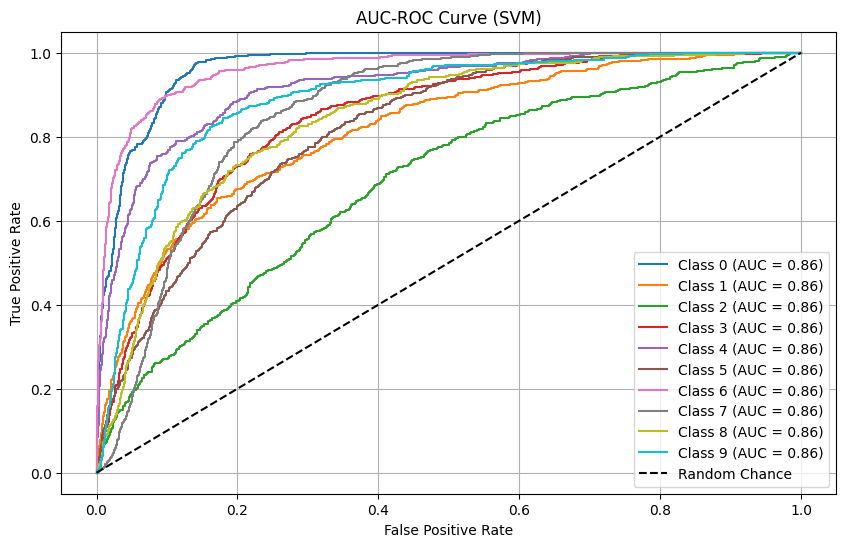

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Reduce dimensions using PCA
pca = PCA(n_components=100)  # Choose components based on explained variance
X_train_subset = X_train[:5000]
y_train_subset = y_train[:5000]
X_test_subset = X_test[:5000]
y_test_subset = y_test[:5000]

X_train_reduced = pca.fit_transform(X_train_subset)
X_test_reduced = pca.transform(X_test_subset)

# Initialize and train a linear SVM
model = SVC(kernel='linear', C=5.0, probability=True)
model.fit(X_train_reduced, y_train_subset)

# Predict on reduced test set
class_label_prediction = model.predict(X_test_reduced)

# Calculate the accuracy score
acc_score = accuracy_score(y_test_subset, class_label_prediction)
print(f"Accuracy Score: {acc_score}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_subset, class_label_prediction)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_labels = sorted(set(y_test_subset))  # Ensure labels match subset
class_report = classification_report(y_test_subset, class_label_prediction, target_names=[str(c) for c in class_labels])
print("\nClassification Report:")
print(class_report)

# AUC-ROC Curve (One-vs-Rest for Multiclass)
y_test_binarized = label_binarize(y_test_subset, classes=class_labels)
y_pred_prob = model.predict_proba(X_test_reduced)

# Compute AUC for each class
auc = roc_auc_score(y_test_binarized, y_pred_prob, average="weighted", multi_class="ovr")
print(f"\nWeighted AUC-ROC Score: {auc}")

# Plot the AUC-ROC curve
plt.figure(figsize=(10, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Diagonal line
plt.title("AUC-ROC Curve (SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

2. CNN

In [ ]:
image_dim = 64
num_channels = 3
X_train = np.reshape(X_train, (-1, image_dim, image_dim, num_channels))
X_test = np.reshape(X_test, (-1, image_dim, image_dim, num_channels))

print (X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Build the CNN model
cnn_model = keras.Sequential()

# 1. Input layer
input_layer = keras.layers.InputLayer(input_shape=(64, 64, 3))  # Adjusted for RGB
cnn_model.add(input_layer)

# 2. First convolutional block
cnn_model.add(keras.layers.Conv2D(16, (3, 3), padding="same"))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.ReLU())

# 3. Second convolutional block
cnn_model.add(keras.layers.Conv2D(32, (3, 3), padding="same"))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.ReLU())

# 4. Third convolutional block
cnn_model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.ReLU())

# 5. Fourth convolutional block
cnn_model.add(keras.layers.Conv2D(128, (3, 3), padding="same"))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.ReLU())

# 6. Fifth convolutional block
cnn_model.add(keras.layers.Conv2D(256, (3, 3), padding="same"))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.ReLU())

# 7. Global average pooling
cnn_model.add(keras.layers.GlobalAveragePooling2D())

#8. Output Layer
cnn_model.add(keras.layers.Dense(10, activation="softmax"))

# Print the model summary
cnn_model.summary()

print("Model completed.")

# Optimization function
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)

# loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# Compile model
cnn_model.compile(optimizer = sgd_optimizer, loss = loss_fn, metrics = ['accuracy'])

# Fit the model
num_epochs = 5 # Number of epochs
t0 = time.time() # start time
cnn_model.fit(X_train, y_train, epochs = num_epochs, validation_split = 0.1) # fit model
t1 = time.time() # stop time
print('Elapsed time: %.2fs' % (t1-t0))

# Evaluating the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

from sklearn.metrics import classification_report

# Get logits (raw model outputs)
logits = cnn_model.predict(X_test)

# Convert logits to class predictions
predictions = logits.argmax(axis=1)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=[str(x) for x in range(0, 10)]))

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot = True, fmt = '0.3f', linewidth = 0.5, square = True, cbar = False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.show()

cnn_model.save('cnnmodel')